In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import sys
import os

from nilearn import plotting, masking, datasets, input_data, image
from nistats.thresholding import map_threshold
from nistats.reporting import get_clusters_table

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [2]:
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')
path_second_level_output = os.path.join(path_nistats, 'second_level_output')
path_mni = os.path.join(path_nistats, ('templates/mni_icbm152_nlin_asym_09c_nifti' 
                                       + '/mni_icbm152_nlin_asym_09c'))

# Directory to save resulting figures
path_out = os.path.join(path_nistats, 'results')
os.makedirs(path_out, exist_ok=True)

In [3]:
# Load MNI 2009c template
mni_09c_t1 = nib.load(
    os.path.join(path_mni, 'mni_icbm152_t1_tal_nlin_asym_09c.nii'))
mni_09c_mask = nib.load(
    os.path.join(path_mni, 'mni_icbm152_t1_tal_nlin_asym_09c_mask.nii'))
mni_09c_clipped = nib.Nifti1Image(
    mni_09c_t1.get_fdata() * mni_09c_mask.get_fdata(), 
    mni_09c_t1.affine, 
    mni_09c_t1.header)

plotting.plot_anat(mni_09c_clipped)

In [4]:
# Load second level SPMs
spm_perr_inc = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_combined_pos.nii'))
spm_perr_dec = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_combined_neg.nii'))
spm_perr_rew_minus_pun = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_rew_minus_pun.nii'))
spm_perr_pun_minus_rew = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_pun_minus_rew.nii'))

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  -6.0  18.0  44.5   7.856539               6741
1         1a   0.0  12.0  51.5   7.813665                   
2          2  15.0   9.0  69.0   6.794687               1165
3          3 -33.0  24.0   6.0   6.504029                945


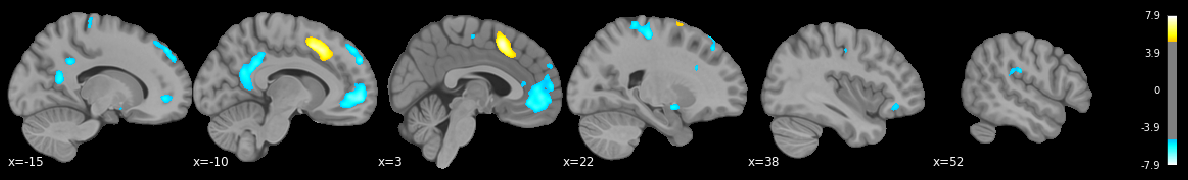

In [10]:
thr_img, thr = map_threshold(
    spm_perr_dec,
    mask_img=mni_09c_mask,
    alpha=0.00001,
    height_control='fdr',
    cluster_threshold=20,
    two_sided=True
)

clusters = get_clusters_table(
    spm_perr_dec, 
    stat_threshold=thr,
    cluster_threshold=20
)

print(clusters)

plotting.plot_stat_map(
    thr_img, 
    bg_img=mni_09c_clipped,
    display_mode='x',
    cut_coords=[-15, -10, 3, 22, 38, 52],
    threshold=thr,
    black_bg=True
)

In [6]:
# aal <- atlas Nifti Image
# aal_fdata <- atlas get_fdata() output
# aal_dict <- must have keys labels and indices
aal = nib.load('./aal_SPM12/aal/atlas/AAL.nii')
aal_fdata = aal.get_fdata()
aal_dict = datasets.fetch_atlas_aal()

def get_label_for_peak(peak):
    
    array_coords = image.coord_transform(*peak, np.linalg.inv(aal.affine))
    
    # Array coordinates
    x, y, z = array_coords
    
    region_number = aal.get_fdata()[round(x), round(y), round(z)]
    try:
        region_index = aal_dict.indices.index(str(int(region_number)))
    except ValueError:
        region_name = '?'
    else:
        region_name = aal_dict.labels[region_index]
    
    return region_name

labels = []
for cluster in clusters.iterrows():
    peak = np.array(cluster[1].loc[['X', 'Y', 'Z']], dtype='float')
    labels.append(get_label_for_peak(peak))
    
labels

['Supp_Motor_Area_L', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Insula_L']